# RESEARCH: Spatial data aggregation

**Author**: gwiazdan  
**Created**: 25-02-2026  
**Version:** 1.0  

In [ ]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from pyfonts import load_google_font
import numpy as np

In [ ]:
gdf_municipality = gpd.read_file("../scripts/geocoder/data/raw/00_jednostki_administracyjne.zip!A03_Granice_gmin.shp")
gdf_municipality = gdf_municipality.to_crs('EPSG:3857')

df = pd.read_csv('../data/final.csv')
df['geometry'] = df['geometry'].astype(str)
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
gdf = gpd.GeoDataFrame(df, crs='EPSG:2180')
gdf = gdf.to_crs('EPSG:3857')

In [ ]:
municipalities_joined = gpd.sjoin(gdf, gdf_municipality, predicate='within', how='left')
municipalities_sum = municipalities_joined.groupby('index_right').agg({
    'psl': 'sum',
    'total_votes': 'sum'
}).reset_index()
municipalities_sum['psl_pct'] = municipalities_sum['psl'] / municipalities_sum['total_votes']
municipalities_final = gdf_municipality.loc[municipalities_sum['index_right']].merge(municipalities_sum['psl_pct'], left_index=True, right_index=True)


In [ ]:
palette_name = "green_material"
cmap = load_cmap(palette_name, cmap_type="continuous")
regular = load_google_font("Roboto")
bold = load_google_font("Roboto", weight="bold")

fig, ax = plt.subplots(dpi=300)
ax.axis("off")
municipalities_final.plot(
    ax=ax,
    column="psl_pct",
    cmap=cmap,
    edgecolor="#e6e6e6",
    lw=0.3,
)

bar_ax = ax.inset_axes(bounds=[0.05, 0.1, 0.3, 0.15], zorder=-1)
n, bins, _ = bar_ax.hist(municipalities_final["psl_pct"], bins=16, alpha=0)
colors = [cmap((val - min(bins)) / (max(bins) - min(bins))) for val in bins]
bar_width = (bins[1] - bins[0]) * 0.8
bar_ax.bar(bins[:-1], n, color=colors, width=bar_width, align="edge")
bar_ax.spines[["top", "left", "right"]].set_visible(False)
bar_ax.set_yticks([])
min_val, max_val = (
    municipalities_final["psl_pct"].min(),
    municipalities_final["psl_pct"].max(),
)
x_ticks = np.linspace(min_val, max_val, 8)
bar_ax.set_xticks(x_ticks)
bar_ax.set_xticklabels([f"{int(x*100)}%" for x in x_ticks], fontsize=4)
bar_ax.tick_params(axis="x", length=2)

fig.text(x=0.2, y=0.89, s="PSL Votes Distribution", size=12, font=bold)
fig.text(
    x=0.2,
    y=0.86,
    s="By municipalities, Spatial Aggregated Dataset",
    size=8,
    font=regular,
)

plt.show()

The map shows spatially aggregated PSL results across Polish municipalities. Support estimates were calculated using k-nearest neighbors (k=4) based on polling station locations from the 2019 parliamentary election data.

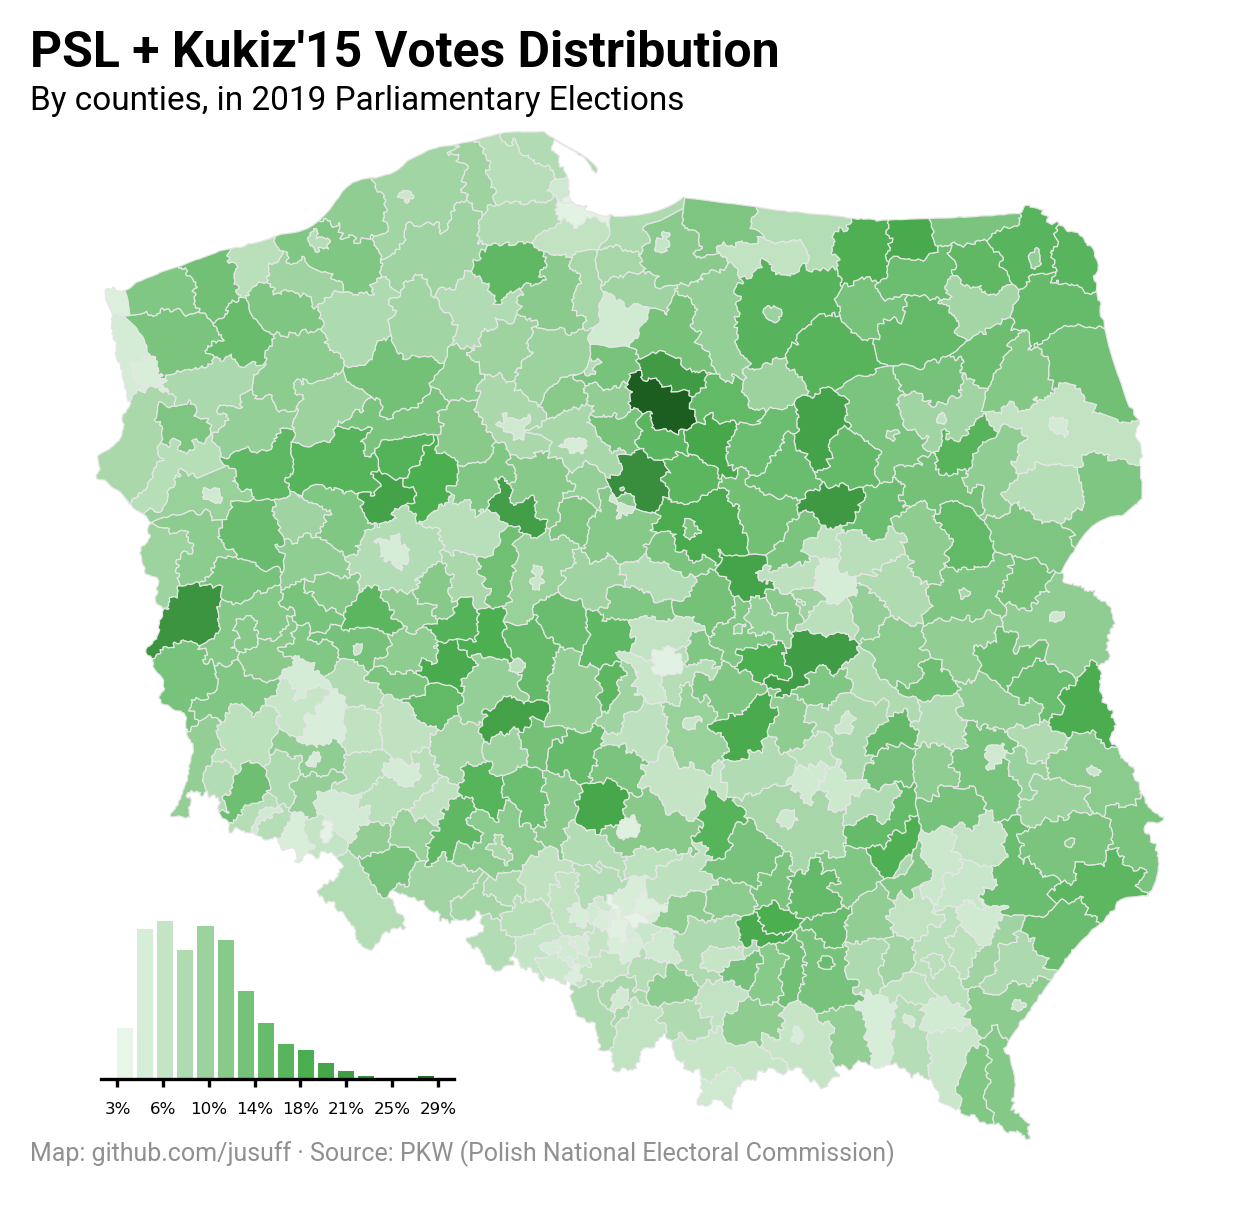

This map displays historical PSL data aggregated column-wise by counties (powiaty) using official PKW reporting units.

### Summary
Spatial aggregation makes perfect sense. It reveals geographic voting patterns that align with official columnar county results, validating the k-NN interpolation method for municipality-level analysis.